In [265]:
import numpy as np 
import matplotlib.pylab as plt 
from scipy.stats import multivariate_normal, norm

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

## Sinusiodal Model

$$
y = A\,\textrm{sin}(\omega t)
$$

The approximate model is:

$$
y \approx A_{*}\,\textrm{sin}(\omega_{*}t) + (A - A_{*})\textrm{sin}(\omega_{*}t) + (\omega - \omega_{*})\,A_{*}t\,\textrm{cos}(\omega_{*}t)
$$

which can be written in matrix format as 

$$
y \approx A_{*}\,\textrm{sin}(\omega_{*}t) - \left[\begin{array}{cc}
\textrm{sin }\omega_{*}t & \;\;A_{*}t\end{array}\,\textrm{cos}\omega_{*}t\right]\left[\begin{array}{c}
A_{*}\\
\omega_{*}
\end{array}\right]+\left[\begin{array}{cc}
\textrm{sin }\omega_{*}t & \;\;A_{*}t\end{array}\,\textrm{cos}\omega_{*}t\right]\left[\begin{array}{c}
A\\
\omega
\end{array}\right]
$$

In [23]:
def model_sin(xvalues, parameters):
    
    function = parameters[0] * np.sin(parameters[1] * xvalues)
    gradient_param_0 = np.sin(parameters[1] * xvalues)
    gradient_param_1 = parameters[0] * xvalues * np.cos(parameters[1] * xvalues)
    
    # this is of shape Ndata x 2 
    gradient = np.vstack([gradient_param_0, gradient_param_1]).T
    return function, gradient

In [33]:
def approximate_sin(xvalues, model_fid, grad_fid, param_fid, new_param):
    delta_param = new_param - param_fid
    func_approx = model_fid + grad_fid @ delta_param
    return func_approx

In [25]:
def model_quad(xvalues, parameters):
    function = parameters[0] * xvalues**2 + parameters[1] * xvalues
    gradient = np.vstack([xvalues**2, xvalues]).T
    return function, gradient

In [142]:
minx = 0.0 
maxx = np.pi 
ndata = 100

param_1_fid = np.array([4.0, 0.75])
param_2_fid = np.array([-1.0, 4.0])

xvalues = np.linspace(minx, maxx, ndata)
model_1_fid, grad_1_fid = model_sin(xvalues, param_1_fid)
model_2_fid, grad_2_fid = model_quad(xvalues, param_2_fid)

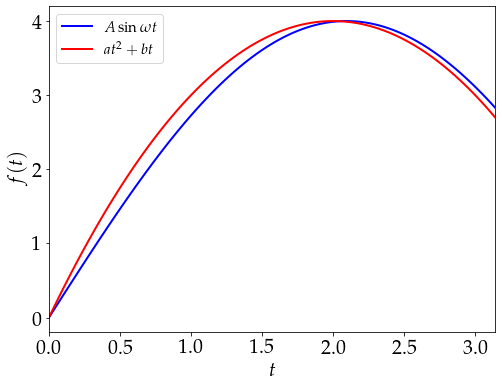

In [143]:
plt.figure(figsize = (8, 6))
plt.plot(xvalues, model_1_fid, c = 'b', label = r'$A\,\textrm{sin}\,\omega t$', lw = 2)
plt.plot(xvalues, model_2_fid, c = 'r', label = r'$at^{2} + bt$', lw=2)
plt.xlim(minx, maxx)
plt.ylabel(r'$f(t)$', fontsize = fontSize)
plt.xlabel(r'$t$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

# Noise and Priors

In [284]:
sigma = 1.5
noise_cov = np.diag(np.ones(ndata)*sigma**2)
noise_invcov = np.diag(1./(np.ones(ndata)*sigma**2))

In [285]:
priorwidth = 10

# we will use beta to denote A and omega 
# we will use theta to denote a and b 
mean_beta = np.zeros(2)
mean_theta = np.zeros(2)

cov_beta = priorwidth * np.eye(2)
cov_theta = priorwidth * np.eye(2)

# priors 

p_beta = multivariate_normal(mean_beta, cov_beta)
p_theta = multivariate_normal(mean_theta, cov_theta)

# Compression Vectors

In [ ]:
B_sin = noise_invcov @ grad_1_fid
B_quad = noise_invcov @ grad_2_fid

# Evidence Calculations (Uncompressed)

In [286]:
difference = model_1_fid - grad_1_fid @ param_1_fid

In [287]:
cov_data_sin = noise_cov + grad_1_fid @ cov_beta @ grad_1_fid.T
cov_data_quad = noise_cov + grad_2_fid @ cov_theta @ grad_2_fid.T

In [288]:
evi_sin = multivariate_normal(grad_1_fid @ mean_beta + difference, cov_data_sin)
evi_quad = multivariate_normal(grad_2_fid @ mean_theta, cov_data_quad)

In [289]:
epsilon = np.random.randn(ndata) * sigma
data = model_1_fid + epsilon

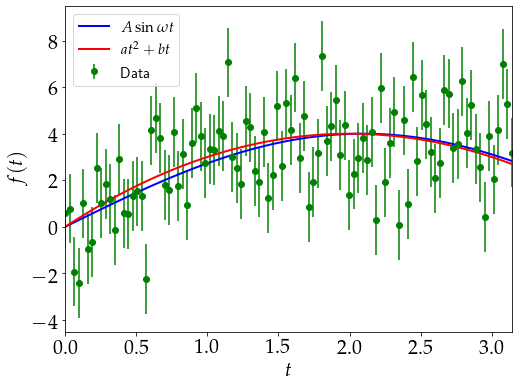

In [290]:
plt.figure(figsize = (8, 6))
plt.errorbar(xvalues, data, yerr = sigma, fmt = 'go', label = 'Data')
plt.plot(xvalues, model_1_fid, c = 'b', label = r'$A\,\textrm{sin}\,\omega t$', lw = 2)
plt.plot(xvalues, model_2_fid, c = 'r', label = r'$at^{2} + bt$', lw=2)
plt.xlim(minx, maxx)
plt.ylabel(r'$f(t)$', fontsize = fontSize)
plt.xlabel(r'$t$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

In [291]:
evi_sin.logpdf(data)

-202.81547021730896

In [292]:
evi_quad.logpdf(data)

-201.0933712709085

In [293]:
evi_sin.logpdf(data) - evi_quad.logpdf(data)

-1.7220989464004504

# Evidence Calculations (Compression)

In [295]:
comp_cov_data_sin = B_sin.T @ (noise_cov + grad_1_fid @ cov_beta @ grad_1_fid.T) @ B_sin
comp_cov_data_quad = B_quad.T @ (noise_cov + grad_2_fid @ cov_theta @ grad_2_fid.T) @ B_quad

In [296]:
comp_evi_sin = multivariate_normal(B_sin.T @ (grad_1_fid @ mean_beta + difference), comp_cov_data_sin)
comp_evi_quad = multivariate_normal(B_quad.T @ (grad_2_fid @ mean_theta), comp_cov_data_quad)

In [297]:
comp_evi_sin.logpdf(B_sin.T @ data)

-14.49403315523606

In [298]:
comp_evi_quad.logpdf(B_sin.T @ data)

-22.439895327699446

In [299]:
comp_evi_sin.logpdf(B_sin.T @ data) - comp_evi_quad.logpdf(B_sin.T @ data)

7.945862172463386

# Repeated Experiments

In [300]:
ntrials = 10000
record = dict()
record['evi_sin'] = list()
record['evi_quad'] = list()
record['bf_sq'] = list()
record['comp_evi_sin'] = list()
record['comp_evi_quad'] = list()
record['comp_bf_sq'] = list()

for i in range(ntrials):
    
    epsilon = np.random.randn(ndata) * sigma
    data = model_1_fid + epsilon
    comp_data_sin = B_sin.T @ data
    comp_data_quad = B_quad.T @ data
    
    # uncompressed
    evi_sin_value = evi_sin.logpdf(data)
    evi_quad_value = evi_quad.logpdf(data)
    record['evi_sin'].append(evi_sin_value)
    record['evi_quad'].append(evi_quad_value)
    record['bf_sq'].append(evi_sin_value - evi_quad_value)
    
    # compressed case 
    comp_evi_sin_value = comp_evi_sin.logpdf(comp_data_sin)
    comp_evi_quad_value = comp_evi_quad.logpdf(comp_data_sin)
    record['comp_evi_sin'].append(comp_evi_sin_value)
    record['comp_evi_quad'].append(comp_evi_quad_value)
    record['comp_bf_sq'].append(comp_evi_sin_value - comp_evi_quad_value)

In [301]:
comp_mu = np.mean(record['comp_bf_sq'])
comp_std = np.std(record['comp_bf_sq'])

mu = np.mean(record['bf_sq'])
std = np.std(record['bf_sq'])

norm_comp = norm(comp_mu, comp_std)
norm_uncomp = norm(mu, std)

min_logbf = min([min(record['comp_bf_sq']), min(record['bf_sq'])])
max_logbf = max([max(record['comp_bf_sq']), max(record['bf_sq'])])

grid_bf = np.linspace(min_logbf, max_logbf, 10000)
pdf_comp = norm_comp.pdf(grid_bf)
pdf_uncomp = norm_uncomp.pdf(grid_bf)

# labels 
label_comp = 'Compression, $\\textrm{log B}_{12}\sim\mathcal{N}$' + f'$(\mu={comp_mu:.3f},\,\sigma={comp_std:.3f})$'
label_uncomp = 'No Compression, $\\textrm{log B}_{12}\sim\mathcal{N}$' + f'$(\mu={mu:.3f},\,\sigma={std:.3f})$'

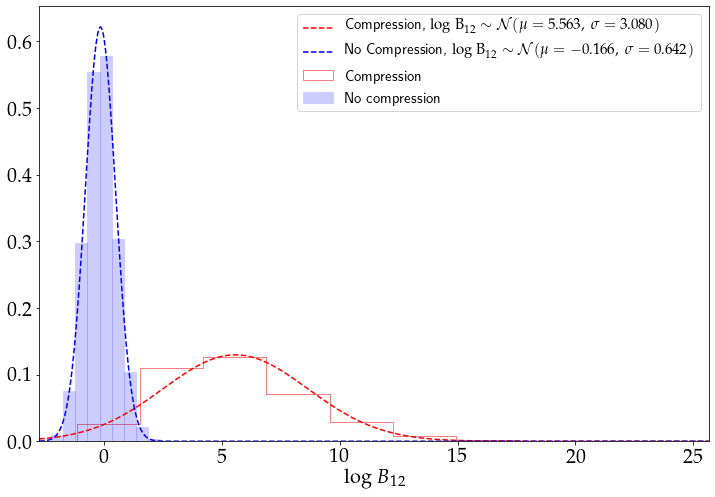

In [302]:
plt.figure(figsize = (12,8))
plt.hist(record['comp_bf_sq'], density = True, edgecolor='r', linewidth=0.5, label = 'Compression', histtype='step')
plt.hist(record['bf_sq'], density = True, edgecolor='b', linewidth=0.5, label = 'No compression', alpha = 0.2, color = 'b')
plt.plot(grid_bf, pdf_comp, label = label_comp, c = 'r', linestyle = '--')
plt.plot(grid_bf, pdf_uncomp, label = label_uncomp, c = 'b', linestyle = '--')
plt.xlabel(r'$\textrm{log }B_{12}$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(min_logbf, max_logbf)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()